# Child Mortality Prediction

**Problem Statement**

Given historical data on child mortality rates across various countries and years, develop a predictive model to forecast child mortality rates. The goal is to identify key factors (such as country, gender, and population) that influence child mortality and to create an accurate prediction model that can help policymakers allocate resources to reduce child mortality in the most vulnerable regions.

**The dataset consists of the following columns:**

* Country - The name of the country.
* Year - The year for which the data is recorded.
* Gender - The gender category (Male or Female).
* Child Mortality (1 to 4) - The number of child deaths in the age group of 1 to 4 years.
* Total Population - The total population for that year and country.
* Mortality Rate - The child mortality rate (likely per 1,000 or per 100,000 population).

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize']=[15,8]

In [3]:
# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
from scipy import stats as st
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.feature_selection import RFE

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PowerTransformer

## Load Dataset

In [5]:
data = pd.read_csv("ChildMOrtalytRate.csv")
data.head()

,Unnamed: 0,Country,Year,Gender,Child Mortality(1 to 4),Total Population,Mortality Rate
0,0,Afghanistan,1967,Female,26012.0,5080.813,5.119653
1,1,Afghanistan,1968,Female,26192.0,5202.606,5.034400
2,2,Afghanistan,1969,Female,26335.0,5333.936,4.937255
3,3,Afghanistan,1970,Female,26562.0,5476.630,4.850063
4,4,Afghanistan,1971,Female,26671.0,5630.099,4.737217


In [6]:
df=data.copy()
df.head()

,Unnamed: 0,Country,Year,Gender,Child Mortality(1 to 4),Total Population,Mortality Rate
0,0,Afghanistan,1967,Female,26012.0,5080.813,5.119653
1,1,Afghanistan,1968,Female,26192.0,5202.606,5.034400
2,2,Afghanistan,1969,Female,26335.0,5333.936,4.937255
3,3,Afghanistan,1970,Female,26562.0,5476.630,4.850063
4,4,Afghanistan,1971,Female,26671.0,5630.099,4.737217


In [7]:
df.shape

(30940, 7)

## Understanding the data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30940 entries, 0 to 30939
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               30940 non-null  int64  
 1   Country                  30940 non-null  object 
 2   Year                     30940 non-null  int64  
 3   Gender                   30940 non-null  object 
 4   Child Mortality(1 to 4)  30940 non-null  float64
 5   Total Population         30064 non-null  float64
 6   Mortality Rate           30064 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


In [9]:
df.drop('Unnamed: 0', axis=1, inplace=True)

**Inference**
- The dataset has 30,940 entries and consists of 7 columns.
- The dataset is fairly complete, but there are some missing values in the "Total Population" and "Mortality Rate" columns.
- The dataset contains 2 categoric columns and 4 numeric columns.
- The dataset has now been cleaned of the unnecessary column, making it more organized and focused on relevant variables.

### Check for duplicates

In [10]:
df.duplicated().sum()

0

**Inference**
- The dataset is free from duplicate entries, ensuring that all records are unique.

### Check Datatypes

In [11]:
df.dtypes

Country                     object
Year                         int64
Gender                      object
Child Mortality(1 to 4)    float64
Total Population           float64
Mortality Rate             float64
dtype: object

### Check for Anamolies

##### Country

In [12]:
df.Country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
       'Croatia', 'Cuba', 'Cyprus', 'Czechia', "Côte d'Ivoire",
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia

In [13]:
df['Country'].value_counts(normalize=True)

Country
Poland         0.006303
Switzerland    0.006303
Canada         0.006303
Seychelles     0.006303
Senegal        0.006303
                 ...   
Timor-Leste    0.002909
San Marino     0.002909
Nauru          0.002909
Andorra        0.002909
Somalia        0.002133
Name: proportion, Length: 194, dtype: float64

##### Gender

In [14]:
df.Gender.unique()

array(['Female', 'Male', 'Total'], dtype=object)

In [15]:
df['Gender'] = df['Gender'].replace({'Total': 'Others'})

- The Gender column has no total values, so it has been changed to "Others."

In [16]:
df['Gender'].value_counts(normalize=True)

Gender
Female    0.334906
Male      0.334906
Others    0.330187
Name: proportion, dtype: float64

## Separate numeric and categorical columns

In [17]:
num = df.select_dtypes(include=np.number).columns.to_list()
cat = df.select_dtypes(exclude=np.number).columns.to_list()

In [18]:
num

['Year', 'Child Mortality(1 to 4)', 'Total Population', 'Mortality Rate']

In [19]:
cat

['Country', 'Gender']

## Basic Analysis

In [20]:
df[num].describe()

,Year,Child Mortality(1 to 4),Total Population,Mortality Rate
count,30940.000000,3.094000e+04,3.006400e+04,30064.000000
mean,1991.456561,1.272722e+04,1.975113e+04,0.959470
std,17.323382,6.370284e+04,8.053780e+04,1.481062
min,1955.000000,0.000000e+00,1.606000e+00,0.000000
25%,1978.000000,6.900000e+01,9.928217e+02,0.044134
50%,1993.000000,6.490000e+02,3.890678e+03,0.225487
75%,2006.000000,6.499500e+03,1.175135e+04,1.292107
max,2019.000000,1.463821e+06,1.433784e+06,10.878031


**Inference**
* Child Mortality and Mortality Rate Variation: The child mortality numbers (ages 1 to 4) and mortality rate show a wide range. The mortality rate varies from 0 to 10.88, indicating significant differences in child mortality between countries and years. While the median mortality rate is 0.225, suggesting that most countries experience relatively low rates, the higher end suggests that some regions face extreme child mortality challenges.
* Population Impact: The total population also shows a large variation, with values ranging from 1,606 to over 1.43 million. The median population is around 3,891, indicating that many countries in the dataset are relatively small, but there are a few with significantly larger populations, which may have a strong influence on the overall mortality rate.

In [21]:
df[cat].describe()

,Country,Gender
count,30940,30940
unique,194,3
top,Poland,Female
freq,195,10362


**Inference**
* The dataset covers 194 unique countries, with Poland having the highest representation (195 occurrences). The gender distribution includes three categories (likely Male, Female, and possibly Unknown or Total), with "Female" being the most frequent, appearing in 10,362 records. This suggests a balanced representation of genders across countries.

#### Lets check distribution of year

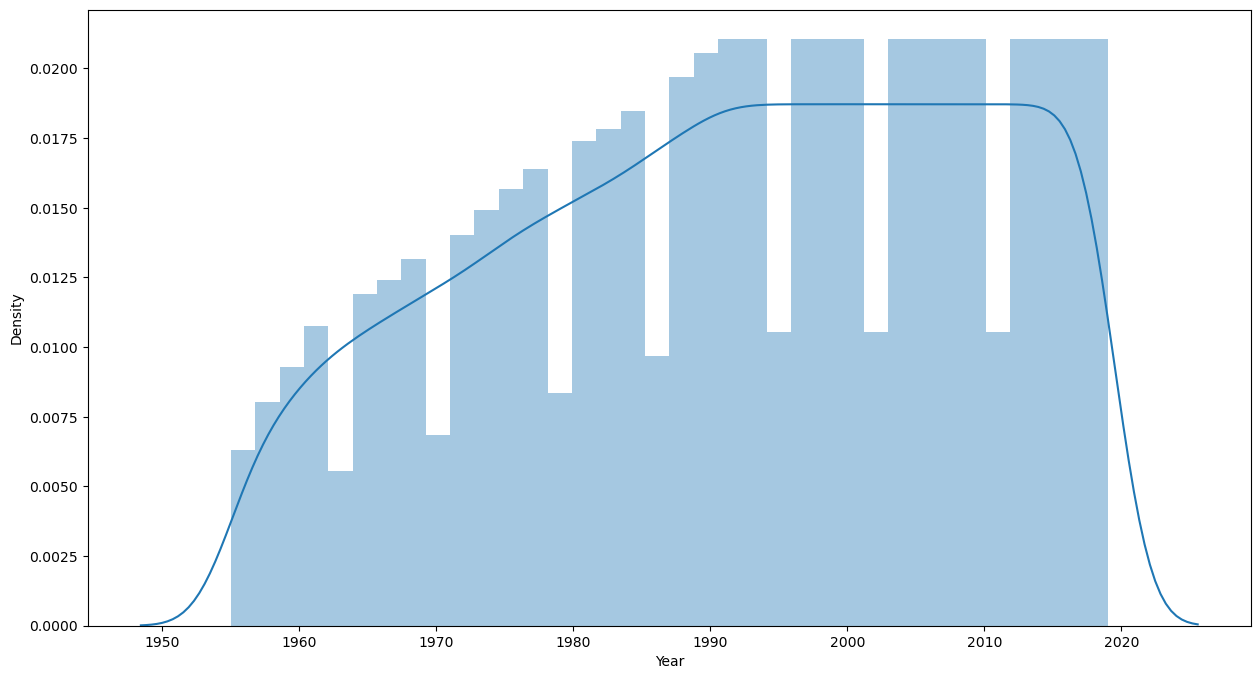

In [22]:
sns.distplot(df['Year'])
plt.show()

## Checking Null Values

In [23]:
df.isnull().sum()

Country                      0
Year                         0
Gender                       0
Child Mortality(1 to 4)      0
Total Population           876
Mortality Rate             876
dtype: int64

In [24]:
(df.isnull().sum()/len(df))*100

Country                    0.000000
Year                       0.000000
Gender                     0.000000
Child Mortality(1 to 4)    0.000000
Total Population           2.831286
Mortality Rate             2.831286
dtype: float64

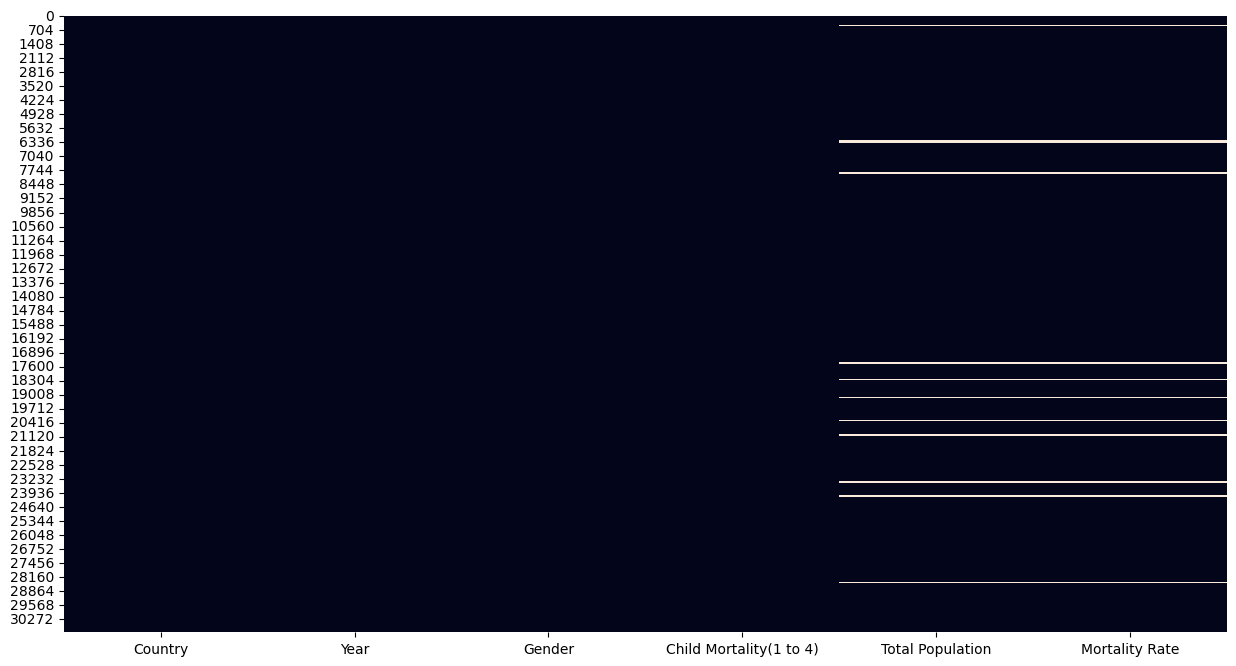

In [25]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

**Inference**
* The dataset contains no missing values for the categorical columns (Country, Year, Gender) and the "Child Mortality (1 to 4)" column. However, about 2.83% of the data is missing in the "Total Population" and "Mortality Rate" columns.

## Check for Outliers

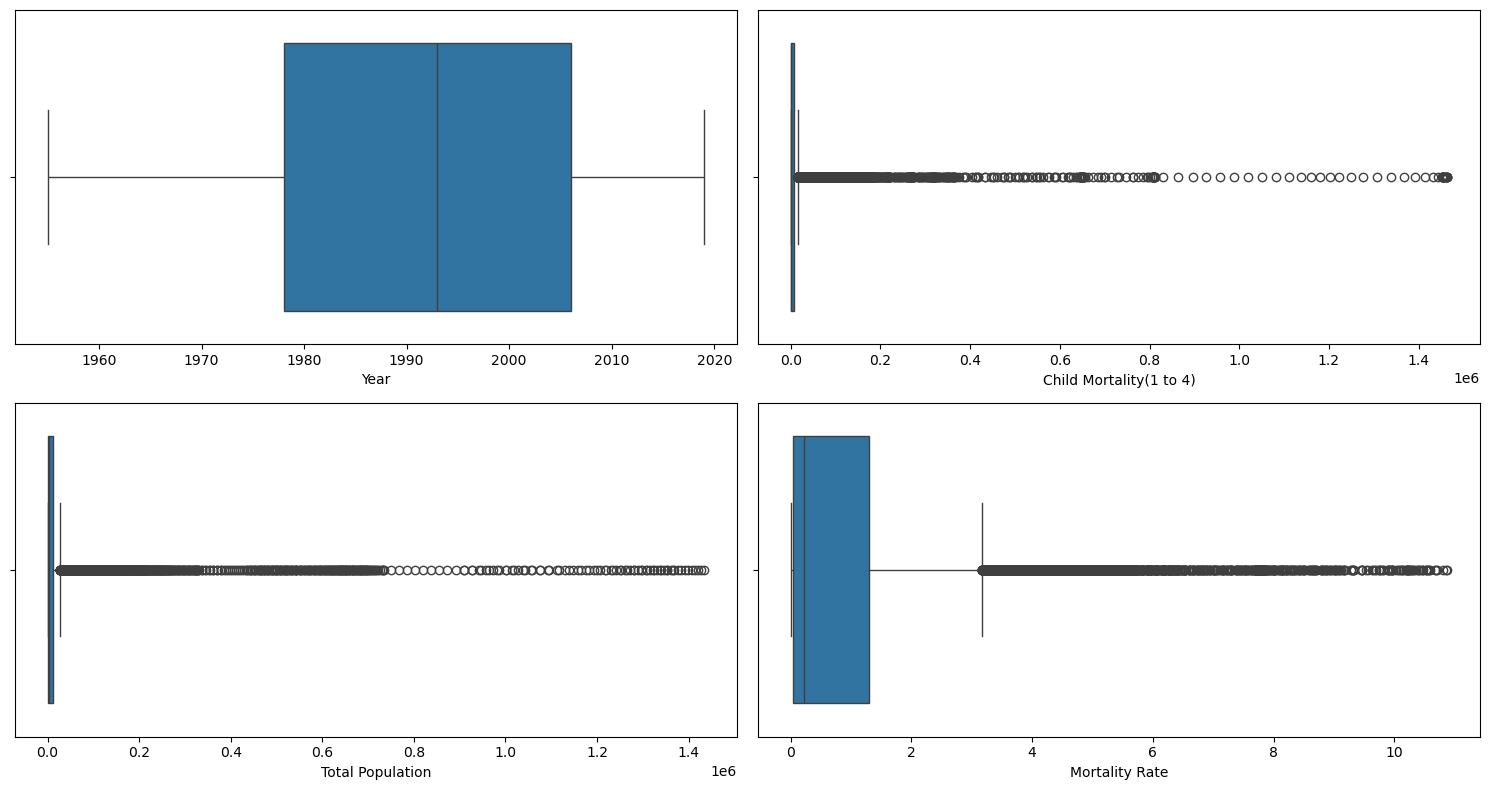

In [26]:
t=1
for i in num:
    plt.subplot(2,2,t)
    sns.boxplot(x= df[i])
    t+=1
plt.tight_layout()
plt.show()

In [27]:
q1 = df[num].quantile(0.25)
q3 = df[num].quantile(0.75)

iqr = q3-q1

ll = q1-(1.5*iqr)
ul = q3+(1.5*iqr)

print(ll)
print(ul)

Year                        1936.000000
Child Mortality(1 to 4)    -9576.750000
Total Population          -15144.975875
Mortality Rate                -1.827826
dtype: float64
Year                        2048.000000
Child Mortality(1 to 4)    16145.250000
Total Population           27889.151125
Mortality Rate                 3.164067
dtype: float64


In [28]:
df[((df[num]<ll) | (df[num]>ul)).any(axis=1)].head()

,Country,Year,Gender,Child Mortality(1 to 4),Total Population,Mortality Rate
0,Afghanistan,1967,Female,26012.0,5080.813,5.119653
1,Afghanistan,1968,Female,26192.0,5202.606,5.034400
2,Afghanistan,1969,Female,26335.0,5333.936,4.937255
3,Afghanistan,1970,Female,26562.0,5476.630,4.850063
4,Afghanistan,1971,Female,26671.0,5630.099,4.737217


In [29]:
(df[((df[num]<ll) | (df[num]>ul)).any(axis=1)].shape[0]/df.shape[0])*100

25.562378797672913

- The outlier percentage in the dataset is 25.56%. For now, we do not need to remove the outliers.

### Treating missing values

In [30]:
df['Total Population'] = df['Total Population'].fillna(df['Total Population'].median())

In [31]:
df['Mortality Rate'] = df['Mortality Rate'].fillna(df['Mortality Rate'].median())

**Inference**
* Outliers were present in the dataset, so the missing values in the columns were imputed with median values.

## Univariate Analysis

#### Numeric columns

In [32]:
df[num].skew()

Year                       -0.246236
Child Mortality(1 to 4)    14.210351
Total Population           10.891850
Mortality Rate              2.444580
dtype: float64

**Inference**
* The negative skewness (-0.246) in the "Year" column suggests that the distribution is fairly symmetrical but slightly skewed to the left, indicating that more records are from recent years, with fewer from earlier years.
* The high positive skewness in "Child Mortality" (14.21) and "Total Population" (10.89) indicates that both distributions are heavily right-skewed. This suggests a concentration of countries with low mortality and smaller populations, while a few countries have exceptionally high values, creating the long right tail.
* The skewness of 2.44 for the mortality rate also shows a right-skewed distribution, indicating that most countries have low mortality rates, but there are some with significantly higher rates, pulling the distribution to the right.

In [33]:
df[num].kurt()

Year                        -0.988583
Child Mortality(1 to 4)    255.695082
Total Population           143.378322
Mortality Rate               7.447306
dtype: float64

**Inference**
* The distribution of the "Year" column has platykurtic characteristics, indicating a flatter distribution with thinner tails compared to a normal distribution. This means the data points are spread more evenly across the years with fewer extreme values or outliers.
* Both "Child Mortality (1 to 4)" and "Total Population" exhibit leptokurtic distributions, which are highly peaked with heavy tails. This suggests that most data points cluster tightly around the mean, but there are extreme outliers, especially in terms of child mortality and population size, contributing to the high kurtosis.
* The mortality rate also shows leptokurtic tendencies, indicating that while most countries have similar mortality rates, a few have extreme values, resulting in a more pronounced peak and thicker tails compared to a normal distribution.

#### Categorical columns

In [34]:
for i in cat:
    print(df[i].unique())
    print()

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' "Côte d'Ivoire" "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran (

In [35]:
for i in cat:
    print(df[i].value_counts())
    print()

Country
Poland         195
Switzerland    195
Canada         195
Seychelles     195
Senegal        195
              ... 
Timor-Leste     90
San Marino      90
Nauru           90
Andorra         90
Somalia         66
Name: count, Length: 194, dtype: int64

Gender
Female    10362
Male      10362
Others    10216
Name: count, dtype: int64



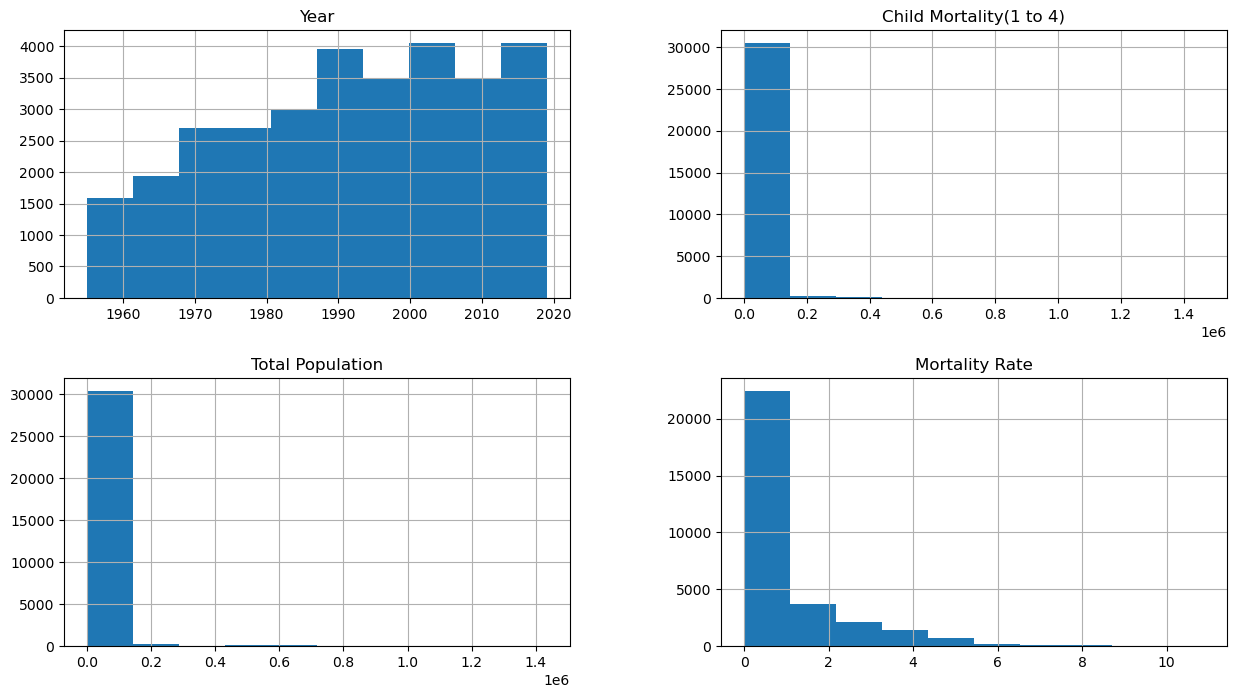

In [36]:
df[num].hist()
plt.show()

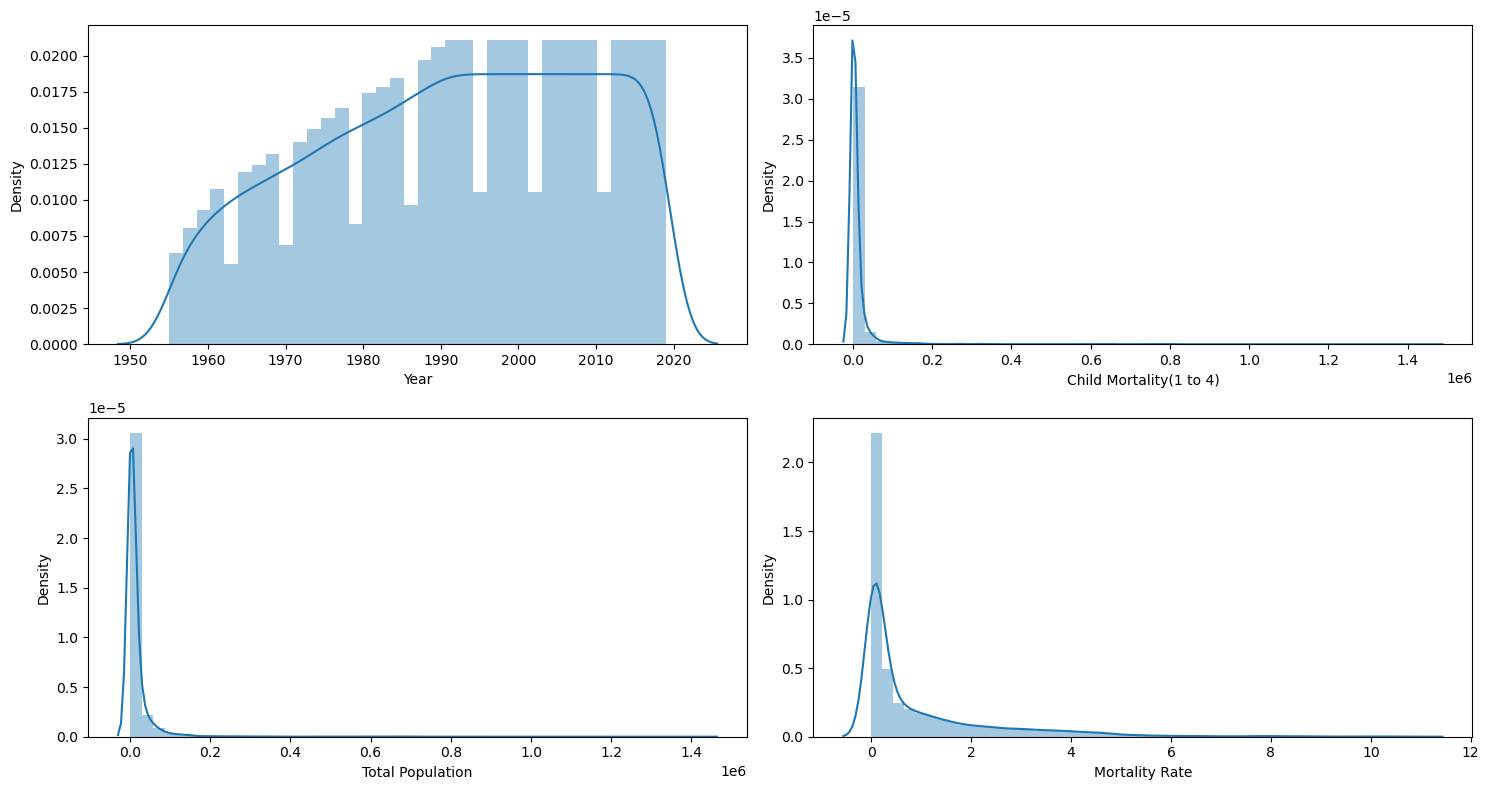

In [37]:
# Numeric columns
t=1
for i in num:
    plt.subplot(2,2,t)
    sns.distplot(df[i])
    t+=1

plt.tight_layout()
plt.show()

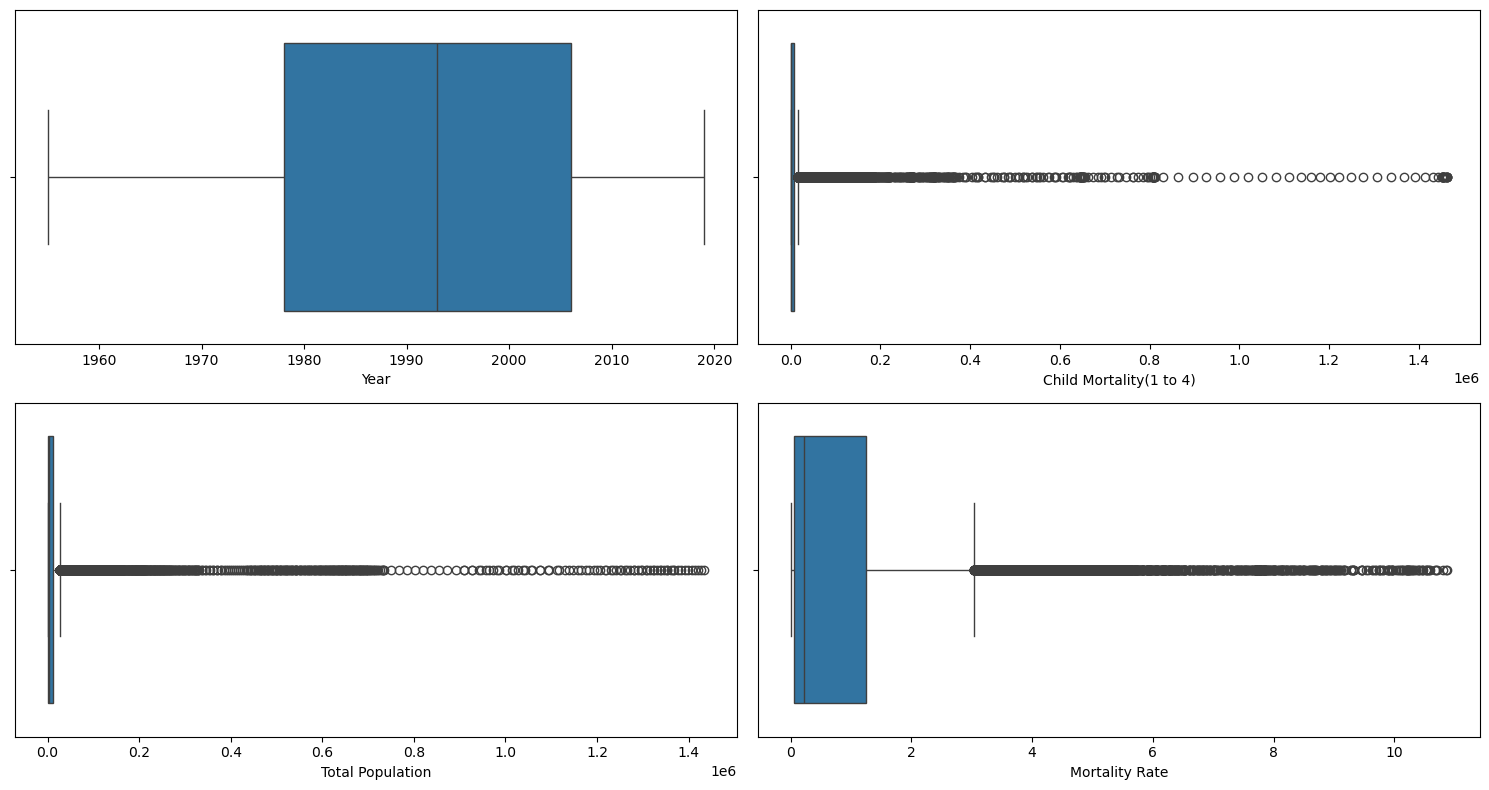

In [38]:
# Numeric columns

t=1
for i in num:
    plt.subplot(2,2,t)
    sns.boxplot(x=df[i])
    t+=1

plt.tight_layout()
plt.show()

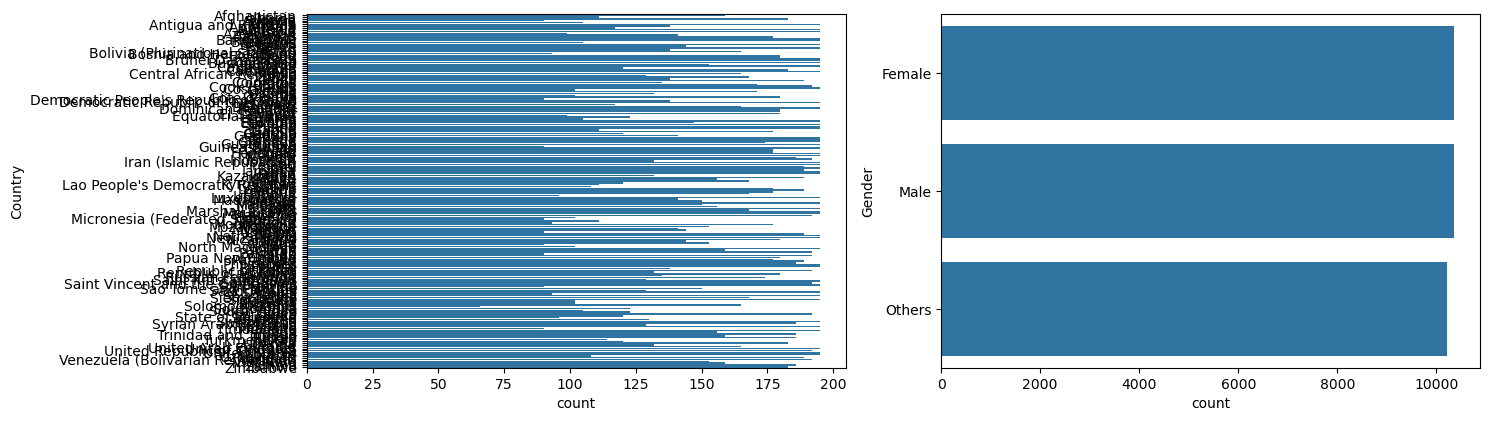

In [39]:
# Categorical columns

t=1
for i in cat:
    plt.subplot(2,2,t)
    sns.countplot(y=df[i])
    t+=1

plt.tight_layout()
plt.show()

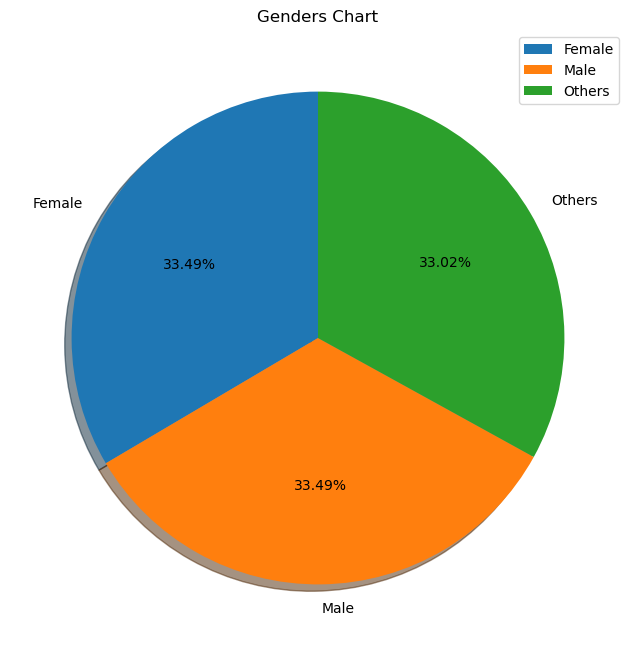

In [40]:
plt.pie(df['Gender'].value_counts(),labels=df['Gender'].unique(),startangle = 90, shadow = True, autopct='%1.2f%%')
plt.legend()
plt.title('Genders Chart')
plt.show()

## Bivariate Analysis

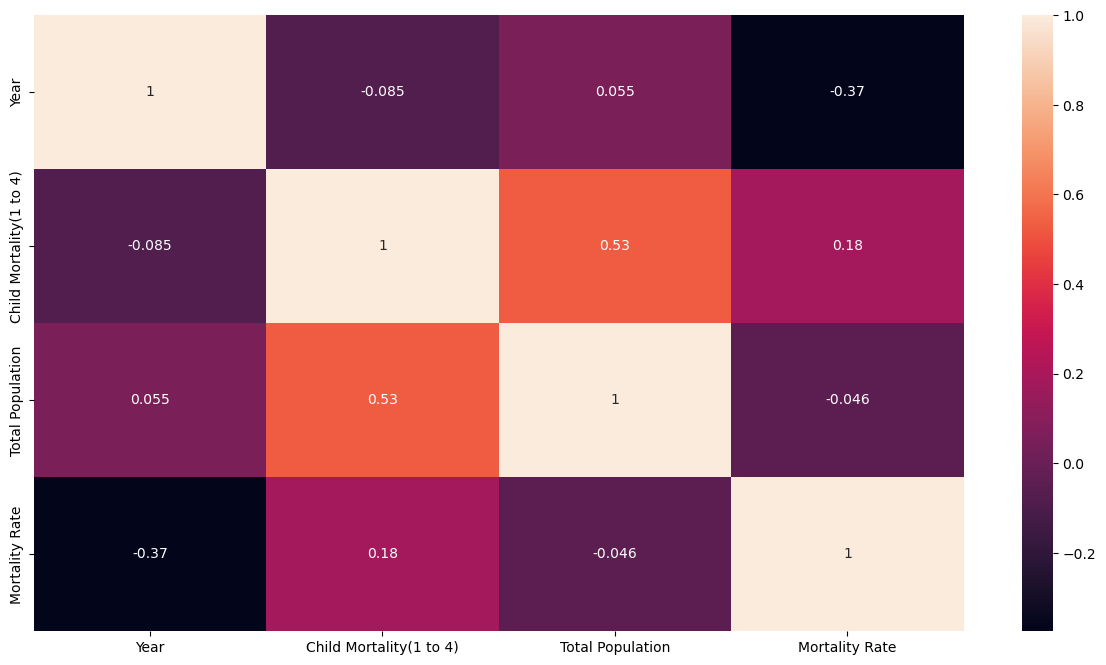

In [41]:
# Numeric vs Numeric

sns.heatmap(df[num].corr(), annot=True)
plt.show()

**Inference**
* "Year" and "Mortality Rate": There is a moderate negative correlation (-0.376) between "Year" and "Mortality Rate," suggesting that child mortality rates have generally decreased over time. As the years progress, mortality rates tend to drop, possibly due to advancements in healthcare, technology, and socioeconomic conditions.
* "Child Mortality (1 to 4)" and "Total Population": A moderate positive correlation (0.532) exists between "Child Mortality" and "Total Population." This indicates that larger populations tend to have higher absolute numbers of child deaths, although this does not necessarily imply a higher rate of mortality—just that more populous countries have more child deaths in absolute terms.
* "Child Mortality (1 to 4)" and "Mortality Rate": The weak positive correlation (0.179) between "Child Mortality" and "Mortality Rate" shows that there is some relationship between the number of child deaths and the mortality rate, but it is not strong, likely due to differences in population size across countries.
* "Total Population" and "Mortality Rate": The correlation between "Total Population" and "Mortality Rate" is very weak (-0.049), suggesting that population size does not have a strong direct impact on the child mortality rate, as other factors like healthcare quality and economic conditions may play a more significant role.

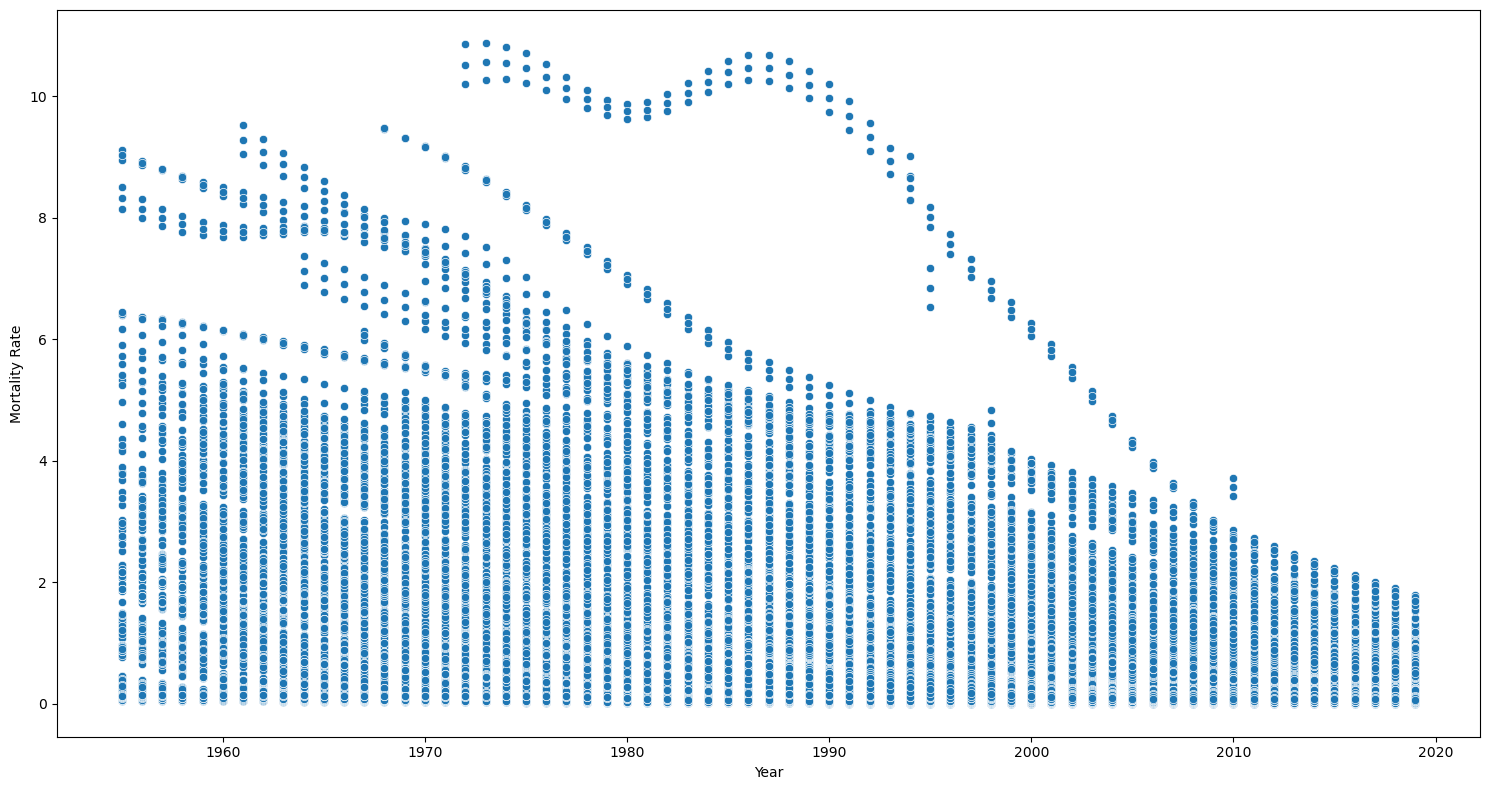

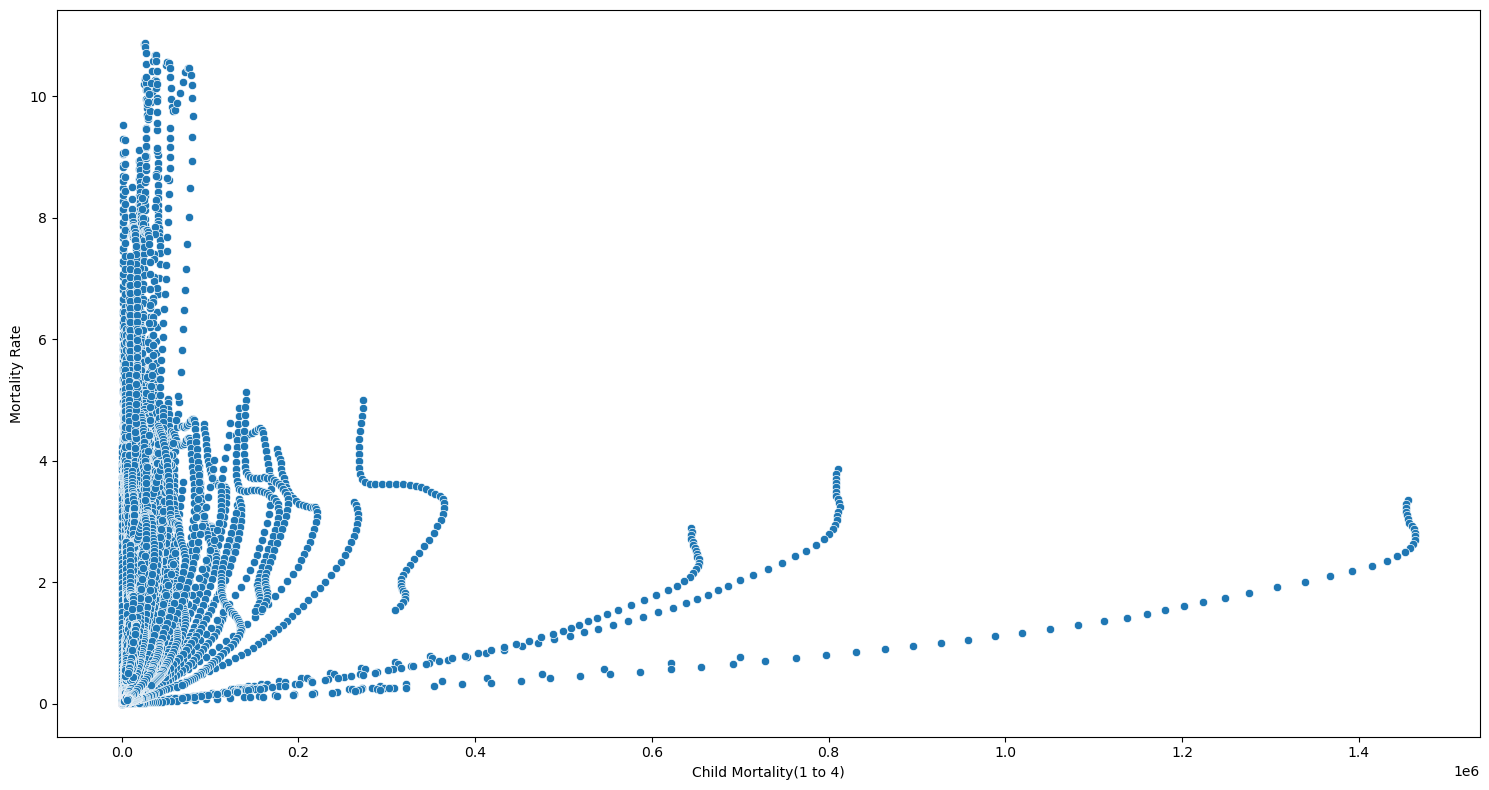

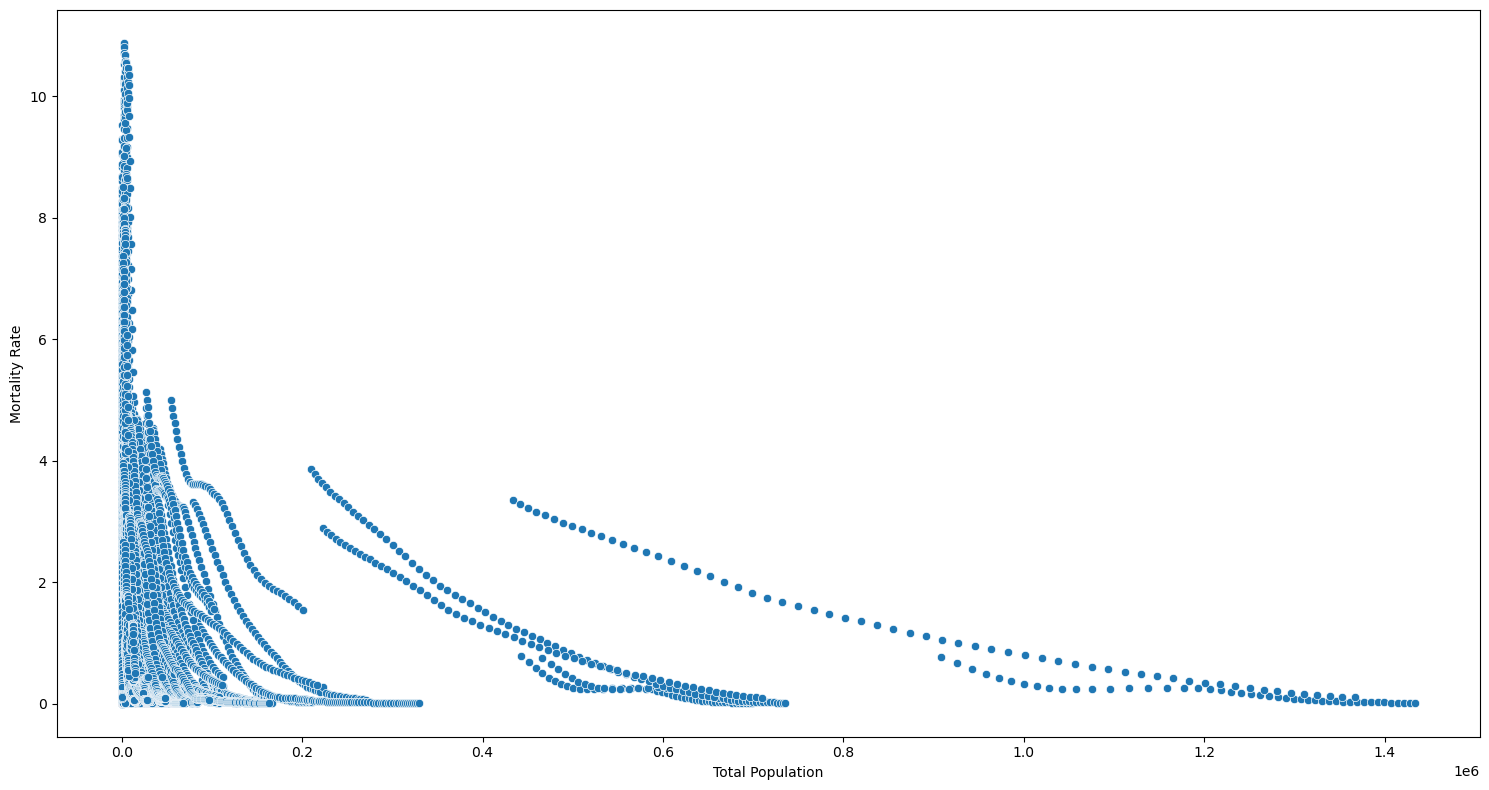

In [42]:
# Numeric vs Numeric columns

for i in num:
    if i != 'Mortality Rate':
        sns.scatterplot(x=df[i], y=df['Mortality Rate'])
        plt.tight_layout()
        plt.show()

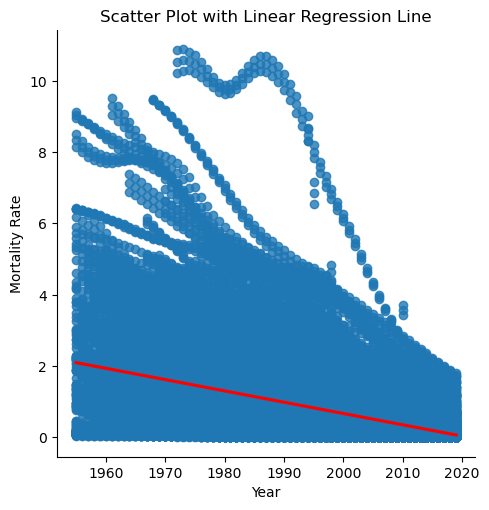

In [43]:
sns.lmplot(x='Year', y='Mortality Rate', data=df, line_kws={'color': 'red'})
plt.title('Scatter Plot with Linear Regression Line')
plt.show()

In [44]:
# Numeric vs Categorical column

for i in cat:
    print(df.groupby(by=i)[['Mortality Rate']].mean())

                                    Mortality Rate
Country                                           
Afghanistan                               2.532872
Albania                                   0.078673
Algeria                                   1.535665
Andorra                                   0.154307
Angola                                    2.942911
...                                            ...
Venezuela (Bolivarian Republic of)        0.296726
Viet Nam                                  0.378387
Yemen                                     2.167745
Zambia                                    2.510464
Zimbabwe                                  1.402606

[194 rows x 1 columns]
        Mortality Rate
Gender                
Female        0.916507
Male          0.959765
Others        0.939811


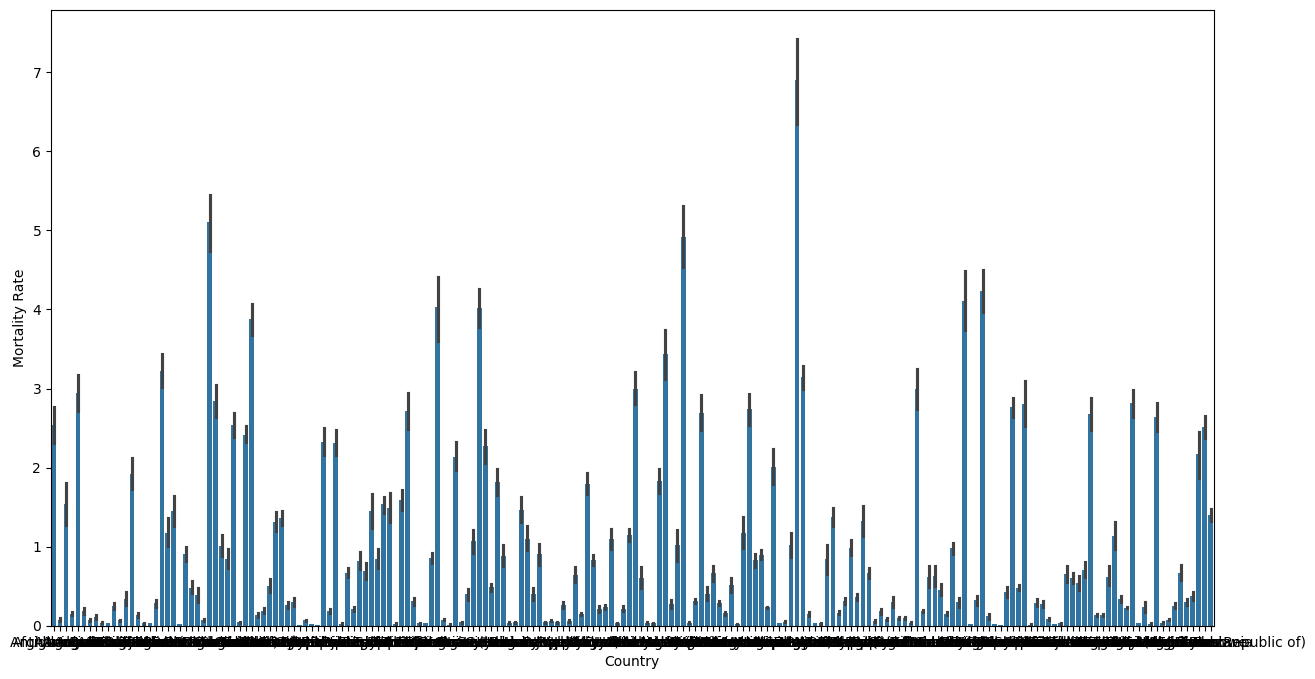

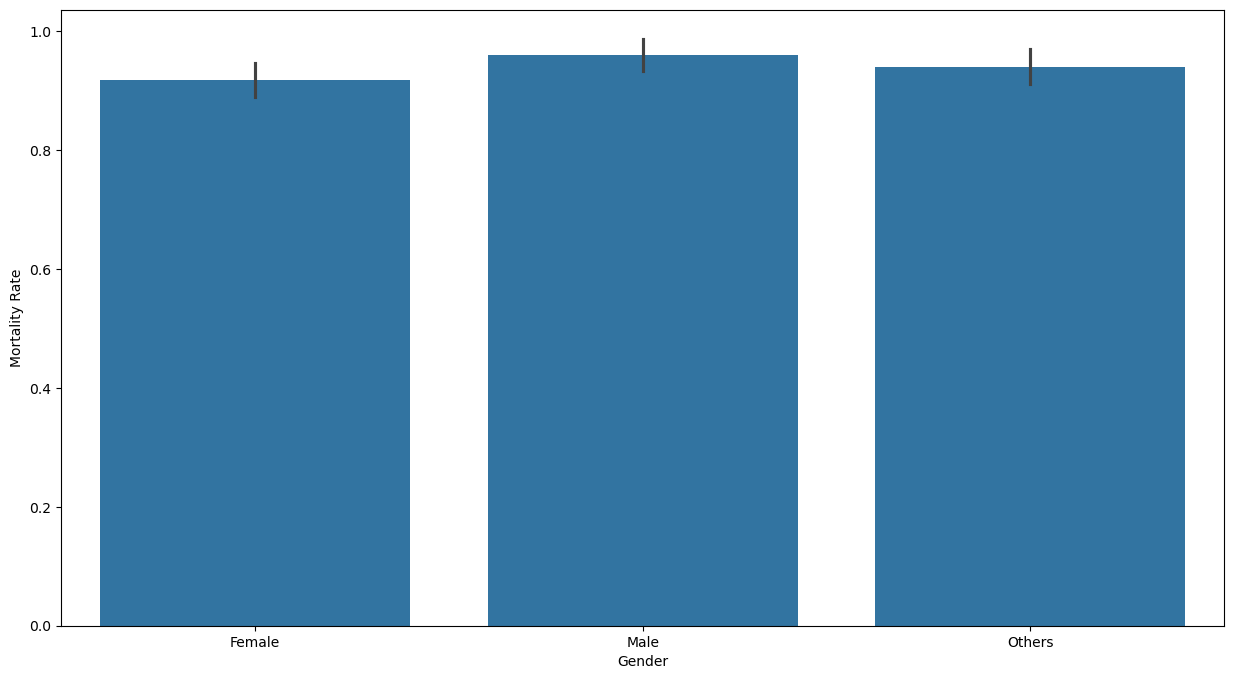

In [45]:
for i in cat:
    sns.barplot(x=df[i], y=df['Mortality Rate'])
    plt.show()

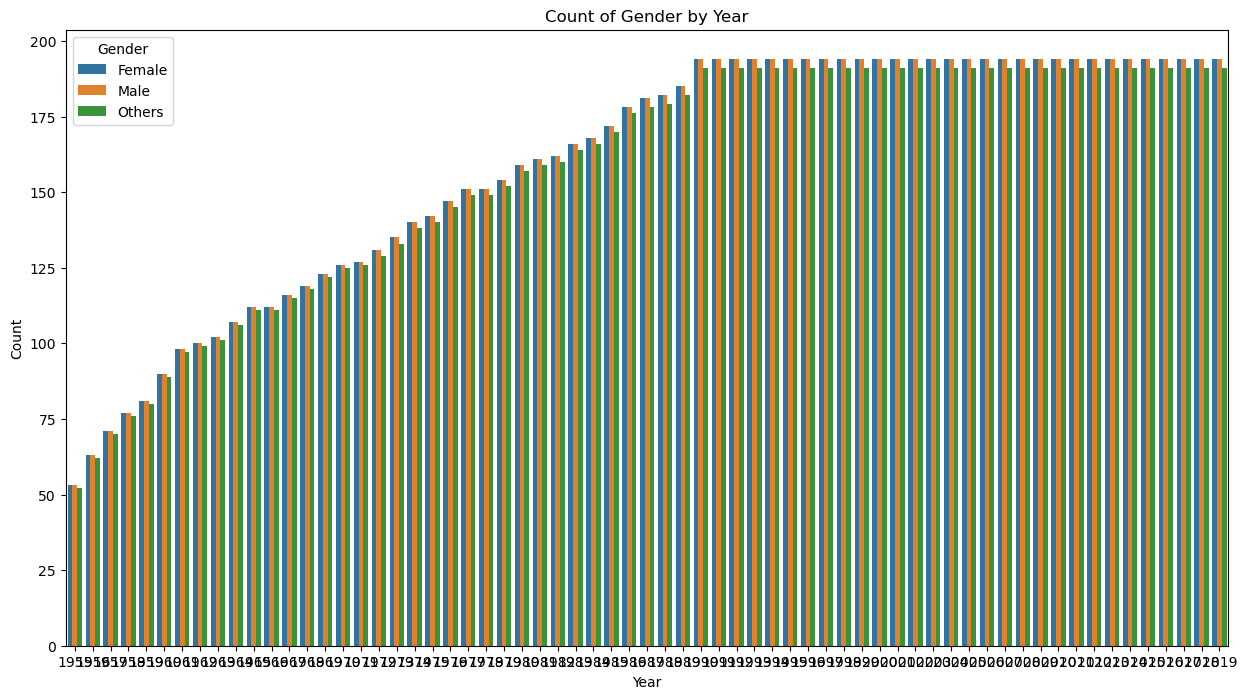

In [46]:
sns.countplot(data=df, x='Year', hue='Gender')
plt.title('Count of Gender by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

## Transformation

In [47]:
num1 = ['Year', 'Child Mortality(1 to 4)', 'Total Population']

In [48]:
pt = PowerTransformer()

In [49]:
df[num1] = pt.fit_transform(df[num1])

In [50]:
df[num1].head()

,Year,Child Mortality(1 to 4),Total Population
0,-1.362963,1.323146,0.195840
1,-1.314875,1.325734,0.207969
2,-1.266398,1.327777,0.220750
3,-1.217530,1.330999,0.234301
4,-1.168268,1.332536,0.248506


In [51]:
df[num1].skew()

Year                      -0.052927
Child Mortality(1 to 4)   -0.014283
Total Population           0.003148
dtype: float64

## Encoding

In [52]:
df['Gender'] = df['Gender'].replace({'Female':0, 'Male':1, 'Others':2})

In [53]:
le = LabelEncoder()

In [54]:
df['Country'] = le.fit_transform(df[['Country']])

In [55]:
df.head()

,Country,Year,Gender,Child Mortality(1 to 4),Total Population,Mortality Rate
0,0,-1.362963,0,1.323146,0.195840,5.119653
1,0,-1.314875,0,1.325734,0.207969,5.034400
2,0,-1.266398,0,1.327777,0.220750,4.937255
3,0,-1.217530,0,1.330999,0.234301,4.850063
4,0,-1.168268,0,1.332536,0.248506,4.737217


## Train Test Split

In [56]:
x = df.drop('Mortality Rate', axis=1)
y = df['Mortality Rate']

In [57]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3, random_state=10)

In [58]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(21658, 5)
(9282, 5)
(21658,)
(9282,)


## Model Building

### Linear regression

In [59]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [60]:
model1 = lr.fit(xtrain, ytrain)

pred_lr_train = model1.predict(xtrain)
pred_lr_test = model1.predict(xtest)

In [61]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [62]:
## RMSE

print("RMSE Train :", np.sqrt(mean_squared_error(ytrain, pred_lr_train)))
print("RMSE Test :", np.sqrt(mean_squared_error(ytest, pred_lr_test)))

RMSE Train : 0.9697287439732224
RMSE Test : 1.0046263679038165


In [63]:
# r2_score (actual, predicted)

r2_train = r2_score(ytrain, pred_lr_train)
r2_test = r2_score(ytest, pred_lr_test)

print("R2 Train :", r2_train)
print("R2 Test :", r2_test)

R2 Train : 0.5545318299227201
R2 Test : 0.5470748546752033


### Decision Tree Regressor

In [64]:
from sklearn.tree import DecisionTreeRegressor

dt=DecisionTreeRegressor(random_state=10)

In [65]:
dt.fit(xtrain, ytrain)
ypred_dt = dt.predict(xtest)

In [66]:
import math

In [67]:
mse = mean_squared_error(ytest, ypred_dt)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 0.08918456184152733


In [68]:
r2 = r2_score(ytest, ypred_dt)
print("R2 Score :", r2)

R2 Score : 0.9964305882167949


##### Feature Importance - Decision Tree regressor

In [69]:
feature_df = pd.DataFrame()
feature_df['Feature'] = xtrain.columns
feature_df['Importances'] = dt.feature_importances_
feature_df = feature_df.sort_values(by='Importances', ascending=False)
feature_df

,Feature,Importances
3,Child Mortality(1 to 4),0.584266
4,Total Population,0.403756
1,Year,0.008054
0,Country,0.003743
2,Gender,0.000182


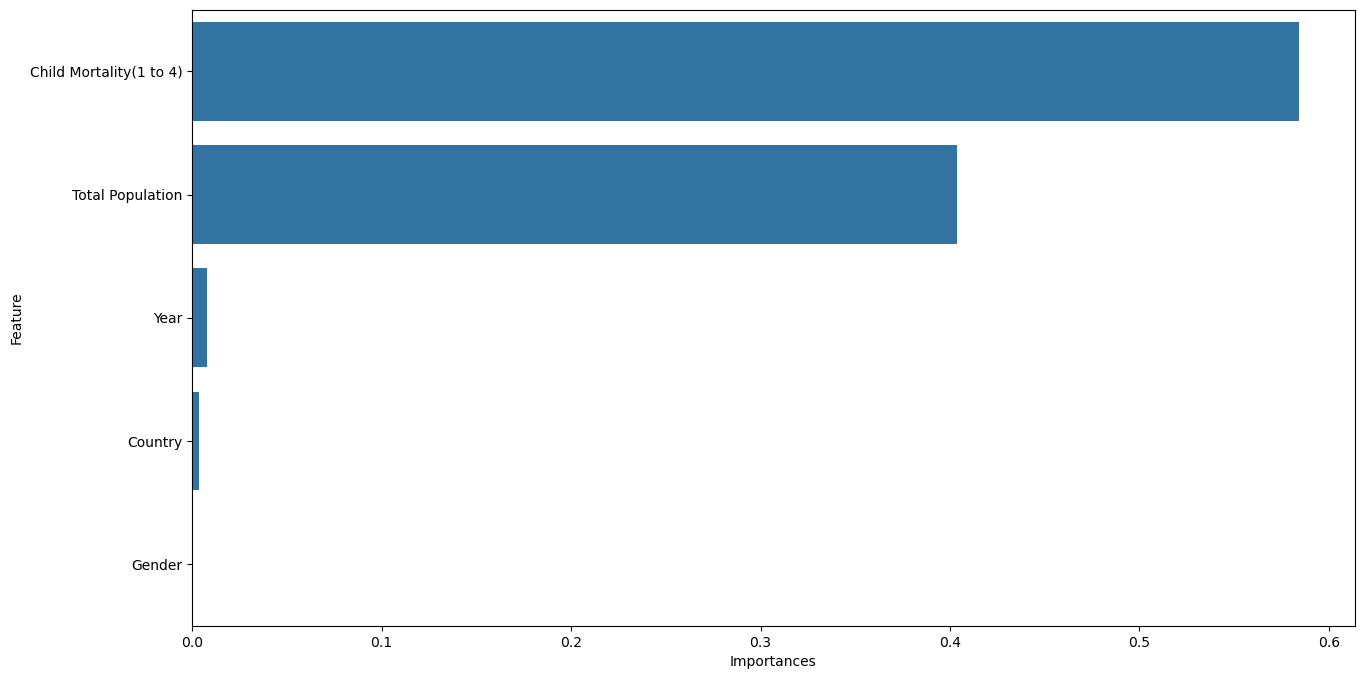

In [70]:
sns.barplot(x='Importances', y='Feature', data=feature_df)
plt.show()

### Ensemble Learning - Bagging

### Random Forest Regressor

In [71]:
from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor(random_state=10)

In [72]:
rf.fit(xtrain, ytrain)
ypred_rf = rf.predict(xtest)

In [73]:
mse = mean_squared_error(ytest, ypred_rf)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 0.057389518790835196


In [74]:
r2 = r2_score(ytest, ypred_rf)
print("R2 Score :", r2)

R2 Score : 0.9985219727080397


In [75]:
rf_compare = pd.DataFrame({'Real Values':ytest, 'Predicted Values': ypred_rf})
rf_compare.head(10)

,Real Values,Predicted Values
26714,0.011051,0.011254
824,0.038854,0.038698
10132,2.264997,2.167661
15120,0.270877,0.277878
18055,1.029591,1.120098
13213,0.173440,0.172390
24181,1.190784,1.184903
29081,0.032722,0.032489
21610,0.224813,0.230882
22515,0.040189,0.040325


### Bagging Regressor

In [76]:
from sklearn.ensemble import BaggingRegressor

br=BaggingRegressor(random_state=10)

In [77]:
br.fit(xtrain, ytrain)
ypred_br = br.predict(xtest)

In [78]:
mse = mean_squared_error(ytest, ypred_br)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 0.06743789031268788


In [79]:
r2 = r2_score(ytest, ypred_br)
print("R2 Score :", r2)

R2 Score : 0.9979590834932393


In [107]:
br_compare = pd.DataFrame({'Real Values':ytest, 'Predicted Values': ypred_br})
br_compare.head(10)

,Real Values,Predicted Values
26714,0.011051,0.011721
824,0.038854,0.040759
10132,2.264997,2.154854
15120,0.270877,0.284711
18055,1.029591,1.019226
13213,0.173440,0.169113
24181,1.190784,1.203115
29081,0.032722,0.032356
21610,0.224813,0.238397
22515,0.040189,0.040432


### Ensemble Learning - Boosting

### Adaboost Regressor

In [80]:
from sklearn.ensemble import AdaBoostRegressor

abr=AdaBoostRegressor(random_state=10)

In [81]:
abr.fit(xtrain, ytrain)
ypred_abr = abr.predict(xtest)

In [82]:
mse = mean_squared_error(ytest, ypred_abr)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 0.8870308253224177


In [83]:
r2 = r2_score(ytest, ypred_abr)
print("R2 Score :", r2)

R2 Score : 0.6469024439400921


### Gradient Boosting Regressor

In [84]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=10)

In [85]:
gbr.fit(xtrain, ytrain)
ypred_gbr = gbr.predict(xtest)

In [86]:
mse = mean_squared_error(ytest, ypred_gbr)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 0.2544965294613267


In [87]:
r2 = r2_score(ytest, ypred_gbr)
print("R2 Score :", r2)

R2 Score : 0.9709342846812826


### XGBoost Regressor

In [88]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=10)

In [89]:
xgb.fit(xtrain, ytrain)
ypred_xgb = xgb.predict(xtest)

In [90]:
mse = mean_squared_error(ytest, ypred_xgb)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 0.07140379561370255


In [91]:
r2 = r2_score(ytest, ypred_xgb)
print("R2 Score :", r2)

R2 Score : 0.9977119796469986


In [92]:
xg_compare = pd.DataFrame({'Real Values':ytest, 'Predicted Values': ypred_xgb})
xg_compare.head(10)

,Real Values,Predicted Values
26714,0.011051,0.014573
824,0.038854,0.043120
10132,2.264997,2.266972
15120,0.270877,0.300568
18055,1.029591,0.940562
13213,0.173440,0.171605
24181,1.190784,1.239632
29081,0.032722,0.024538
21610,0.224813,0.262283
22515,0.040189,0.044721


In [93]:
## Optimised code

perf_score = pd.DataFrame(columns=['Model', 'Alpha', 'L1_Ratio','R2_Train','R2_Test','RMSE Train','RMSE TEST','MAPE' ] )

In [99]:
def per_measures(model):

   #-----------------------------------------------#
   # Calculation of R square and Adj R2            #
   #-----------------------------------------------#

   # calculate rsquare value

    rsq_train = model.score(xtrain, ytrain)
    rsq_test  = model.score(xtest, ytest)

    # calculating adjusted rsquare value
    n =xtrain.shape[0]
    k = xtrain.shape[1]
    rsq_adj = 1 - ((1-rsq_test)*(n-1)/(n-k-1))


   #-----------------------------------------------#
   # Model getting trained                         #
   #-----------------------------------------------#

    model.fit(xtrain,ytrain)

    pred_train = model.predict(xtrain)
    pred_test = model.predict(xtest)

   #-----------------------------------------------#
   # Calculation of RMSE and MAPE                  #
   #-----------------------------------------------#

    rmse_train =np.sqrt(mean_squared_error(ytrain,pred_train))
    rmse_test  =np.sqrt(mean_squared_error(ytest,pred_test))


    MAPE_test = (np.mean(np.abs((ytest - pred_test) / ytest)) * 100)


    return (rsq_train,rsq_test,rmse_train,rmse_test,MAPE_test)

In [100]:
def update_performance (name, model, alpha = '-', l1_ratio = '-' ):


    # assign 'comp_perf' as global variable
    global perf_score


    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    perf_score = pd.concat([perf_score,
                            pd.DataFrame({ 'Model'          : [name],
                                          'Alpha'          : [alpha],
                                          'L1_Ratio'       : [l1_ratio],
                                          'R2_Train'       : [per_measures(model)[0]],
                                          'R2_Test'        : [per_measures(model)[1]],
                                          'RMSE Train'     : [per_measures(model)[2]],
                                          'RMSE TEST'      : [per_measures(model)[3]],
                                          'MAPE'           : [per_measures(model)[4]]
                                          })],
                                          ignore_index = True)

In [101]:
update_performance(name = 'Linear Regression', model = model1)

perf_score

,Model,Alpha,L1_Ratio,R2_Train,R2_Test,RMSE Train,RMSE TEST,MAPE
0,Linear Regression,-,-,0.554532,0.547075,0.969729,1.004626,inf


In [102]:
update_performance(name='Decision Tree regressor', model=dt)

perf_score

,Model,Alpha,L1_Ratio,R2_Train,R2_Test,RMSE Train,RMSE TEST,MAPE
0,Linear Regression,-,-,0.554532,0.547075,9.697287e-01,1.004626,inf
1,Decision Tree regressor,-,-,1.000000,0.996431,8.965946e-11,0.089185,inf


In [103]:
update_performance(name='Bagging regressor', model=br)

perf_score

,Model,Alpha,L1_Ratio,R2_Train,R2_Test,RMSE Train,RMSE TEST,MAPE
0,Linear Regression,-,-,0.554532,0.547075,9.697287e-01,1.004626,inf
1,Decision Tree regressor,-,-,1.000000,0.996431,8.965946e-11,0.089185,inf
2,Bagging regressor,-,-,0.999709,0.997959,2.480051e-02,0.067438,inf


In [104]:
update_performance(name='Ada Boost regressor', model=abr)

perf_score

,Model,Alpha,L1_Ratio,R2_Train,R2_Test,RMSE Train,RMSE TEST,MAPE
0,Linear Regression,-,-,0.554532,0.547075,9.697287e-01,1.004626,inf
1,Decision Tree regressor,-,-,1.000000,0.996431,8.965946e-11,0.089185,inf
2,Bagging regressor,-,-,0.999709,0.997959,2.480051e-02,0.067438,inf
3,Ada Boost regressor,-,-,0.633775,0.646902,8.792567e-01,0.887031,inf


In [105]:
update_performance(name='Gradient Boosting regressor', model=gbr)

perf_score

,Model,Alpha,L1_Ratio,R2_Train,R2_Test,RMSE Train,RMSE TEST,MAPE
0,Linear Regression,-,-,0.554532,0.547075,9.697287e-01,1.004626,inf
1,Decision Tree regressor,-,-,1.000000,0.996431,8.965946e-11,0.089185,inf
2,Bagging regressor,-,-,0.999709,0.997959,2.480051e-02,0.067438,inf
3,Ada Boost regressor,-,-,0.633775,0.646902,8.792567e-01,0.887031,inf
4,Gradient Boosting regressor,-,-,0.975633,0.970934,2.267988e-01,0.254497,inf


In [106]:
update_performance(name='XG boost regressor', model=xgb)

perf_score

,Model,Alpha,L1_Ratio,R2_Train,R2_Test,RMSE Train,RMSE TEST,MAPE
0,Linear Regression,-,-,0.554532,0.547075,9.697287e-01,1.004626,inf
1,Decision Tree regressor,-,-,1.000000,0.996431,8.965946e-11,0.089185,inf
2,Bagging regressor,-,-,0.999709,0.997959,2.480051e-02,0.067438,inf
3,Ada Boost regressor,-,-,0.633775,0.646902,8.792567e-01,0.887031,inf
4,Gradient Boosting regressor,-,-,0.975633,0.970934,2.267988e-01,0.254497,inf
5,XG boost regressor,-,-,0.999116,0.997712,4.319870e-02,0.071404,inf
